In [1]:
import os
import numpy as np
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# Parameters and Dataset Loading
# -----------------------------
data_dir = "RAVDESS_mel_spectrograms"  # Base directory; must have one subfolder per class
batch_size = 32
img_size = (224, 224)  # Expected input size for VGG16
seed = 123

# Load raw datasets with an 80/20 train-validation split
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Save class names before caching/prefetching
class_names = raw_train_ds.class_names
print("Class names:", class_names)

# For performance, cache and prefetch the datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 1440 files belonging to 8 classes.
Using 1152 files for training.
Found 1440 files belonging to 8 classes.
Using 288 files for validation.
Class names: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [3]:
# -----------------------------
# CNN for Feature Extraction
# -----------------------------
# Load a pretrained VGG16 model (without its top layers) and add a global average pooling layer.
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)


In [4]:
# -----------------------------
# Function to Extract Embeddings
# -----------------------------
def get_embeddings(dataset, model):
    """
    Iterates over the dataset to extract CNN embeddings.
    Preprocesses the images for VGG16 and collects embeddings and labels.
    """
    embeddings = []
    labels = []
    for batch_images, batch_labels in dataset:
        batch_images = preprocess_input(batch_images)
        batch_emb = model.predict(batch_images)
        embeddings.append(batch_emb)
        labels.append(batch_labels.numpy())
    return np.vstack(embeddings), np.hstack(labels)

print("Extracting features for training set...")
X_train, y_train = get_embeddings(train_ds, feature_extractor)
print("Extracting features for validation set...")
X_val, y_val = get_embeddings(val_ds, feature_extractor)

print("Training embeddings shape:", X_train.shape)
print("Validation embeddings shape:", X_val.shape)

# Ensure labels are integers
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)


Extracting features for training set...
1/1 [==============================] - 0s 12ms/step
Extracting features for validation set...
1/1 [==============================] - 0s 17ms/step
Training embeddings shape: (1152, 512)
Validation embeddings shape: (288, 512)


In [5]:
# -----------------------------
# XGBoost Classification with Hyperparameter Optimization via RandomizedSearchCV
# -----------------------------
num_classes = len(class_names)

# Define the parameter grid for random search
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [5, 7, 9, 11],
    'n_estimators': [200, 300, 500, 1000],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1, 5]
}

# Initialize the base XGBoost classifier
base_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=num_classes,
    eval_metric="mlogloss",
)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=param_dist,
    n_iter=2,                # Number of parameter settings that are sampled
    scoring='accuracy',
    cv=5,                     # 5-fold cross-validation
    verbose=1,
    random_state=seed,
    n_jobs=-1
)

print("Starting hyperparameter optimization with RandomizedSearchCV...")
random_search.fit(X_train, y_train)

print("\nBest Hyperparameters Found:")
print(random_search.best_params_)

# Get the best estimator
best_clf = random_search.best_estimator_


Starting hyperparameter optimization with RandomizedSearchCV...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Hyperparameters Found:
{'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 11, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.9}



Validation Accuracy: 55.56%

Classification Report:
              precision    recall  f1-score   support

       angry       0.58      0.64      0.61        33
        calm       0.51      0.69      0.59        36
     disgust       0.64      0.56      0.60        50
     fearful       0.64      0.54      0.58        39
       happy       0.43      0.56      0.49        36
     neutral       0.50      0.33      0.40        18
         sad       0.58      0.34      0.43        41
   surprised       0.57      0.71      0.63        35

    accuracy                           0.56       288
   macro avg       0.56      0.55      0.54       288
weighted avg       0.56      0.56      0.55       288



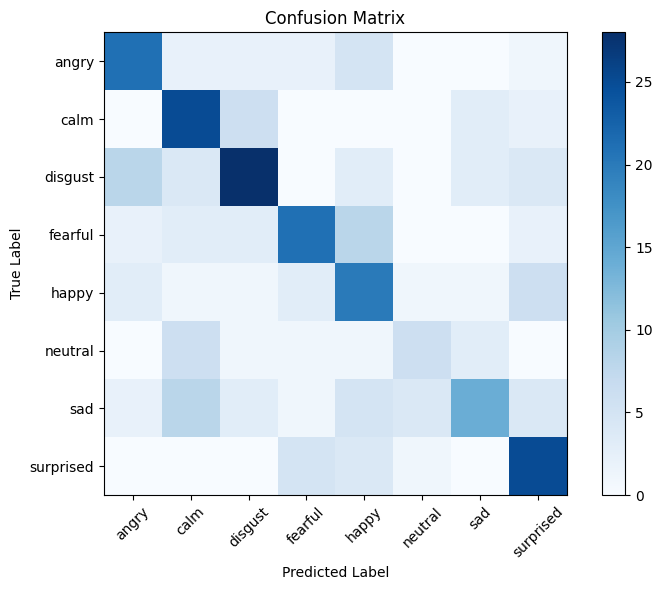

In [6]:
# -----------------------------
# Evaluation on Validation Set
# -----------------------------
y_pred = best_clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("\nValidation Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
